In [3]:
from fastai import * 
from fastai.data.all import *
from fastai.vision.data import * 
from fastai.vision.core import *
from fastai.vision.all import *
from torchvision import transforms
from torch_lr_finder import LRFinder
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data as data
from torch import nn, optim
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
import re
import os
import glob
from skimage import io, color, img_as_float32, img_as_uint
import random
import numpy as np
import PIL
import glob
import gc
from torch.optim.lr_scheduler import _LRScheduler
from sklearn.metrics import fbeta_score
import sys
import builtins
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix
import pickle
import pandas
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.manifold import SpectralEmbedding
from sklearn.preprocessing import MinMaxScaler

/home/fs541623/.conda/envs/fastai/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
## Load Data 
fnames = get_image_files('/hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Cropped_Cells')

In [48]:
## Helper functions for converting between binary and interpretable labels
def label_decoder(labels):
    label_array=np.array(list(labels_encoder))
    idx = np.array(labels).astype(int) > 0 
    return label_array[idx]
def label_func(fname):
    return (re.match(r'.*(Time_\d+hrs).*(Well_\d+).*', fname.name).groups())
## Get truth 
def get_labels(one_hot):
    labels= list()
    for i in one_hot:
        label = label_decoder(i)
        labels.append(label)
    return labels

In [6]:
labels = np.unique(list(zip(*(set(fnames.map(label_func))))))
label_n = len(np.unique(labels))
classes=len(labels)
labels_encoder = {metadata:l for l, metadata in enumerate(labels)}

### Dimensionality reduction of Deep learning features

In [7]:
## Load X, predictions, and truth labels
x,y,z = pd.read_pickle(r'/hpc/scratch/hdd2/fs541623/Bash_scripts/representations_copy_full_3.pkl')

In [49]:
## Convert from one hot to words
predictions = get_labels(y)
ground_truth = get_labels(z)
df1 = pd.DataFrame(predictions)
df2 = pd.DataFrame(ground_truth)

In [50]:
## Remove zero variance features 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X_new = SelectKBest(chi2, k=800).fit_transform(x, y)
df3 = pd.DataFrame(X_new)

In [51]:
## colnames for features
df3.columns = [('Feature_' + str(i))  for i in range(1, df3.shape[1]+1)]
df1 = df1.rename(columns={0:'Time_prediction', 1:'Concentration_prediction'})
df2 = df2.rename(columns={0:'Time_label', 1:'Concentration_label'})

In [52]:
## Concatenate Dataframe on rows 
concat = pd.concat([df3, df1, df2], axis=1, keys=['X','pred', 'truth'])

In [53]:
## flatten multidimensional dataframe as I dont know how to make plot otherwise
concat.columns = [(str(col[1])) for col in concat.columns.values]

In [13]:
## PCA ## 
pca = PCA(n_components=20)
pca_result = pca.fit_transform(df3)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance PCA: 0.8826318612902743


In [14]:
full_pc_df = pd.DataFrame(pca_result)
## join PCA df with predictions and labels
pca_df = pd.concat([full_pc_df, df1, df2])

In [15]:
## Signficant PCs using elbowplot heuristic 
var = pd.DataFrame(pca.explained_variance_)
sns.barplot(x=var['index'], y=var[0])

KeyError: 'index'

In [ ]:
## PCA plot labelled by concentration 
plt.figure(figsize=(20,15))
sns.scatterplot(pca_result[:,0], pca_result[:,1], hue=df2['Concentration_label'], s=10, alpha=0.9)
plt.savefig('pca_plot_concentration_label.png')
## PCA plot labelled by time 
plt.figure(figsize=(20,15))
sns.scatterplot(pca_result[:,0], pca_result[:,1], hue=df2['Time_label'], s=10, alpha=0.9)
plt.savefig('pca_plot_time_label.png')

In [ ]:
## Show effect of concentration for each timepoint 
plt.figure(figsize=(20,15))
g = sns.FacetGrid(test_df, col='Time_label', col_wrap=3)
g.map_dataframe(sns.scatterplot, x='PC1', y='PC2', hue='Concentration_label', s=3, alpha=0.2)
g.set_axis_labels("PC1", "PC2")
g.add_legend()
plt.savefig('pca_plot_faceted_by_time.png')
## Show effect of time for each concentration 
plt.figure(figsize=(20,15))
g = sns.FacetGrid(test_df, col='Concentration_label', col_wrap=3)
g.map_dataframe(sns.scatterplot, x='PC1', y='PC2', hue='Time_label', s=3, alpha=0.2)
g.set_axis_labels("PC1", "PC2")
g.add_legend()
plt.savefig('pca_plot_faceted_by_conc.png')

In [14]:
x = pd.read_csv(r'/hpc/scratch/hdd2/fs541623/Cell_Tox_Assay_080421/FEATURE_EXTRACTION/representations_top800.csv')

/home/fs541623/.conda/envs/fastai/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (804,805,806) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [16]:
#Run T-SNE on the PCA features.
tsne = TSNE(n_components=2, verbose = 1, perplexity=70).fit_transform(full_pc_df.iloc[:, 0:2])

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 892104 samples in 0.811s...
[t-SNE] Computed neighbors for 892104 samples in 38.778s...
[t-SNE] Computed conditional probabilities for sample 1000 / 892104
[t-SNE] Computed conditional probabilities for sample 2000 / 892104
[t-SNE] Computed conditional probabilities for sample 3000 / 892104
[t-SNE] Computed conditional probabilities for sample 4000 / 892104
[t-SNE] Computed conditional probabilities for sample 5000 / 892104
[t-SNE] Computed conditional probabilities for sample 6000 / 892104
[t-SNE] Computed conditional probabilities for sample 7000 / 892104
[t-SNE] Computed conditional probabilities for sample 8000 / 892104
[t-SNE] Computed conditional probabilities for sample 9000 / 892104
[t-SNE] Computed conditional probabilities for sample 10000 / 892104
[t-SNE] Computed conditional probabilities for sample 11000 / 892104
[t-SNE] Computed conditional probabilities for sample 12000 / 892104
[t-SNE] Computed conditional proba

[t-SNE] Computed conditional probabilities for sample 122000 / 892104
[t-SNE] Computed conditional probabilities for sample 123000 / 892104
[t-SNE] Computed conditional probabilities for sample 124000 / 892104
[t-SNE] Computed conditional probabilities for sample 125000 / 892104
[t-SNE] Computed conditional probabilities for sample 126000 / 892104
[t-SNE] Computed conditional probabilities for sample 127000 / 892104
[t-SNE] Computed conditional probabilities for sample 128000 / 892104
[t-SNE] Computed conditional probabilities for sample 129000 / 892104
[t-SNE] Computed conditional probabilities for sample 130000 / 892104
[t-SNE] Computed conditional probabilities for sample 131000 / 892104
[t-SNE] Computed conditional probabilities for sample 132000 / 892104
[t-SNE] Computed conditional probabilities for sample 133000 / 892104
[t-SNE] Computed conditional probabilities for sample 134000 / 892104
[t-SNE] Computed conditional probabilities for sample 135000 / 892104
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 240000 / 892104
[t-SNE] Computed conditional probabilities for sample 241000 / 892104
[t-SNE] Computed conditional probabilities for sample 242000 / 892104
[t-SNE] Computed conditional probabilities for sample 243000 / 892104
[t-SNE] Computed conditional probabilities for sample 244000 / 892104
[t-SNE] Computed conditional probabilities for sample 245000 / 892104
[t-SNE] Computed conditional probabilities for sample 246000 / 892104
[t-SNE] Computed conditional probabilities for sample 247000 / 892104
[t-SNE] Computed conditional probabilities for sample 248000 / 892104
[t-SNE] Computed conditional probabilities for sample 249000 / 892104
[t-SNE] Computed conditional probabilities for sample 250000 / 892104
[t-SNE] Computed conditional probabilities for sample 251000 / 892104
[t-SNE] Computed conditional probabilities for sample 252000 / 892104
[t-SNE] Computed conditional probabilities for sample 253000 / 892104
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 367000 / 892104
[t-SNE] Computed conditional probabilities for sample 368000 / 892104
[t-SNE] Computed conditional probabilities for sample 369000 / 892104
[t-SNE] Computed conditional probabilities for sample 370000 / 892104
[t-SNE] Computed conditional probabilities for sample 371000 / 892104
[t-SNE] Computed conditional probabilities for sample 372000 / 892104
[t-SNE] Computed conditional probabilities for sample 373000 / 892104
[t-SNE] Computed conditional probabilities for sample 374000 / 892104
[t-SNE] Computed conditional probabilities for sample 375000 / 892104
[t-SNE] Computed conditional probabilities for sample 376000 / 892104
[t-SNE] Computed conditional probabilities for sample 377000 / 892104
[t-SNE] Computed conditional probabilities for sample 378000 / 892104
[t-SNE] Computed conditional probabilities for sample 379000 / 892104
[t-SNE] Computed conditional probabilities for sample 380000 / 892104
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 488000 / 892104
[t-SNE] Computed conditional probabilities for sample 489000 / 892104
[t-SNE] Computed conditional probabilities for sample 490000 / 892104
[t-SNE] Computed conditional probabilities for sample 491000 / 892104
[t-SNE] Computed conditional probabilities for sample 492000 / 892104
[t-SNE] Computed conditional probabilities for sample 493000 / 892104
[t-SNE] Computed conditional probabilities for sample 494000 / 892104
[t-SNE] Computed conditional probabilities for sample 495000 / 892104
[t-SNE] Computed conditional probabilities for sample 496000 / 892104
[t-SNE] Computed conditional probabilities for sample 497000 / 892104
[t-SNE] Computed conditional probabilities for sample 498000 / 892104
[t-SNE] Computed conditional probabilities for sample 499000 / 892104
[t-SNE] Computed conditional probabilities for sample 500000 / 892104
[t-SNE] Computed conditional probabilities for sample 501000 / 892104
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 607000 / 892104
[t-SNE] Computed conditional probabilities for sample 608000 / 892104
[t-SNE] Computed conditional probabilities for sample 609000 / 892104
[t-SNE] Computed conditional probabilities for sample 610000 / 892104
[t-SNE] Computed conditional probabilities for sample 611000 / 892104
[t-SNE] Computed conditional probabilities for sample 612000 / 892104
[t-SNE] Computed conditional probabilities for sample 613000 / 892104
[t-SNE] Computed conditional probabilities for sample 614000 / 892104
[t-SNE] Computed conditional probabilities for sample 615000 / 892104
[t-SNE] Computed conditional probabilities for sample 616000 / 892104
[t-SNE] Computed conditional probabilities for sample 617000 / 892104
[t-SNE] Computed conditional probabilities for sample 618000 / 892104
[t-SNE] Computed conditional probabilities for sample 619000 / 892104
[t-SNE] Computed conditional probabilities for sample 620000 / 892104
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 729000 / 892104
[t-SNE] Computed conditional probabilities for sample 730000 / 892104
[t-SNE] Computed conditional probabilities for sample 731000 / 892104
[t-SNE] Computed conditional probabilities for sample 732000 / 892104
[t-SNE] Computed conditional probabilities for sample 733000 / 892104
[t-SNE] Computed conditional probabilities for sample 734000 / 892104
[t-SNE] Computed conditional probabilities for sample 735000 / 892104
[t-SNE] Computed conditional probabilities for sample 736000 / 892104
[t-SNE] Computed conditional probabilities for sample 737000 / 892104
[t-SNE] Computed conditional probabilities for sample 738000 / 892104
[t-SNE] Computed conditional probabilities for sample 739000 / 892104
[t-SNE] Computed conditional probabilities for sample 740000 / 892104
[t-SNE] Computed conditional probabilities for sample 741000 / 892104
[t-SNE] Computed conditional probabilities for sample 742000 / 892104
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 850000 / 892104
[t-SNE] Computed conditional probabilities for sample 851000 / 892104
[t-SNE] Computed conditional probabilities for sample 852000 / 892104
[t-SNE] Computed conditional probabilities for sample 853000 / 892104
[t-SNE] Computed conditional probabilities for sample 854000 / 892104
[t-SNE] Computed conditional probabilities for sample 855000 / 892104
[t-SNE] Computed conditional probabilities for sample 856000 / 892104
[t-SNE] Computed conditional probabilities for sample 857000 / 892104
[t-SNE] Computed conditional probabilities for sample 858000 / 892104
[t-SNE] Computed conditional probabilities for sample 859000 / 892104
[t-SNE] Computed conditional probabilities for sample 860000 / 892104
[t-SNE] Computed conditional probabilities for sample 861000 / 892104
[t-SNE] Computed conditional probabilities for sample 862000 / 892104
[t-SNE] Computed conditional probabilities for sample 863000 / 892104
[t-SNE] Computed con

In [54]:
tsne_df = pd.concat([pd.DataFrame(tsne), df1, df2],  axis=1)

In [42]:
tsne_df = pd.DataFrame(tsne)

In [19]:
tsne_df.to_pickle('tsne_results_3pcs.pkl')

In [18]:
tsne_results = pd.read_pickle('tsne_results.pkl').rename(columns={0:'TSNE_1', 1:'TSNE_2'})

FileNotFoundError: [Errno 2] No such file or directory: 'tsne_results.pkl'

In [ ]:
plt.figure(figsize=(20,15))
g = sns.FacetGrid(test_df, col='Concentration_label', col_wrap=3)
g.map_dataframe(sns.scatterplot, x='PC1', y='PC2', hue='Time_label', s=3, alpha=0.2)
g.set_axis_labels("PC1", "PC2")
g.add_legend()
plt.savefig('pca_plot_faceted_by_conc.png')

In [46]:
df3['Concentration']

KeyError: 'Concentration'

In [57]:
tsne_df

,0,1,Time_prediction,Concentration_prediction,2,3,4,5,Time_label,Concentration_label
0,10.304867,-8.675329,Time_72hrs,Well_17,None,None,None,None,Time_72hrs,Well_17
1,-7.580331,9.721487,Time_72hrs,Well_17,None,None,None,None,Time_72hrs,Well_17
2,-11.592442,9.414264,Time_72hrs,Well_17,None,None,None,None,Time_72hrs,Well_17
3,-1.017955,8.430908,Time_72hrs,Well_17,None,None,None,None,Time_72hrs,Well_17
4,0.515684,0.259803,Time_72hrs,Well_17,None,None,None,None,Time_72hrs,Well_17
...,...,...,...,...,...,...,...,...,...,...
892099,-3.024288,9.435761,Time_48hrs,Time_72hrs,Well_14,None,None,None,Time_72hrs,Well_14
892100,-4.748918,21.778147,Time_72hrs,Well_14,None,None,None,None,Time_72hrs,Well_14
892101,-10.560813,4.826974,Well_14,None,None,None,None,None,Time_72hrs,Well_14
892102,1.714049,-12.446902,Time_72hrs,Well_14,None,None,None,None,Time_72hrs,Well_14


/home/fs541623/.conda/envs/fastai/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


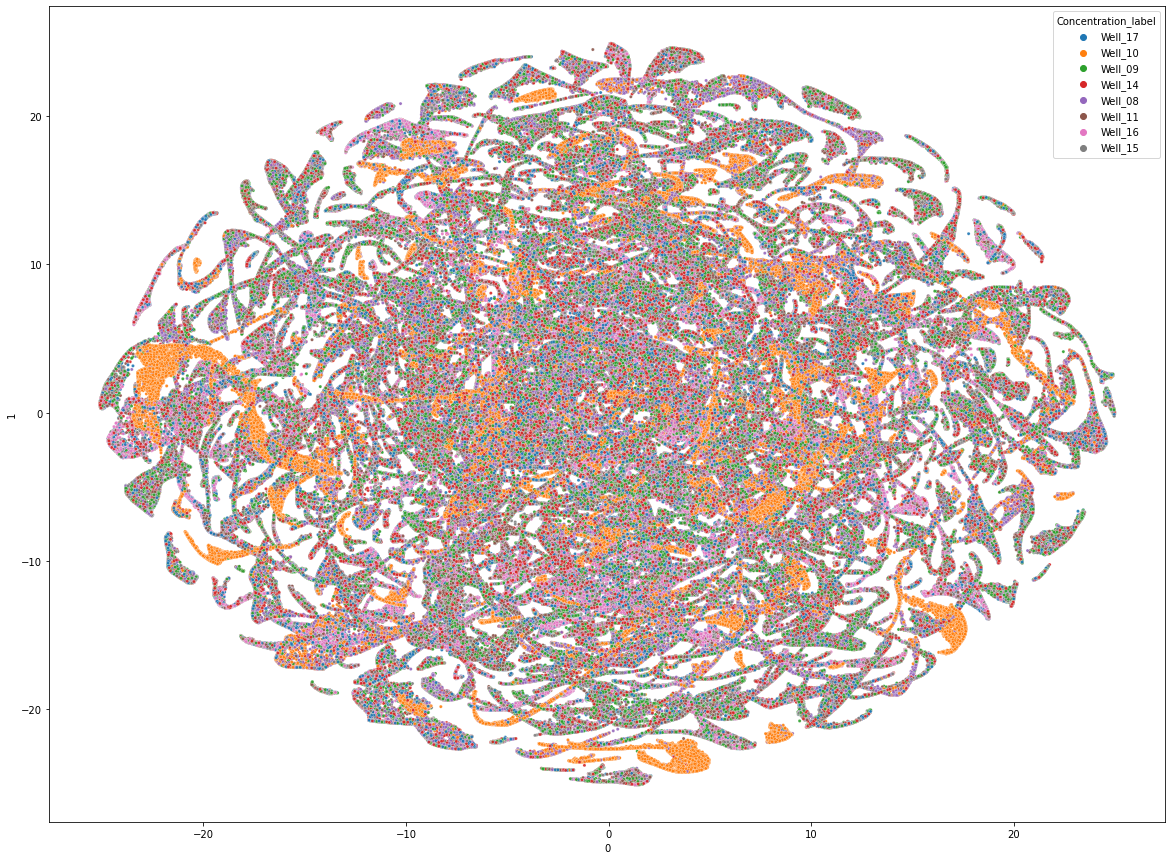

In [58]:
## TSNE plot 
plt.figure(figsize=(20,15))
sns.scatterplot(tsne_df[0], tsne_df[1], hue=tsne_df['Concentration_label'], s=10, alpha=0.9)
plt.savefig('tsne_plot_concentration_label.png')

In [ ]:
### Diffusion map - spectral embedding 
se = SpectralEmbedding(n_components=2).fit_transform(full_pc_df.iloc[:, 0:5])
pd.DataFrame(se).to_pickle('spectral_embedding_results.pkl')

In [ ]:
## Heatmap of features across time
g=sns.heatmap(df3, cmap = sns.diverging_palette(20,220,n=200), yticklabels=1)

In [ ]:
?sns.clustermap

### Cell profiler features 

In [ ]:
#### Concatenate all features from cp together 
file='/hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Data/*/*/FilteredCytObj.csv'
df = (pd.read_csv(f) for f in glob.glob(file))
df = pd.concat(df) 

In [ ]:
df = pd.read_csv(r'/hpc/scratch/hdd2/fs541623/Cell_Tox_Assay_080421/FEATURE_EXTRACTION/CP_features.csv')

In [ ]:
## Get labels for plotting
labels = df['FileName_Cyt'].str.extract(r'.*(Time_\d+hrs).*(Well_\d+).*').rename(columns={0:'Time', 1:'Concentration'})
df_feat = pd.concat([df, labels], axis=1)

In [ ]:
plt.figure(figsize=(20,15))
g = sns.FacetGrid(df_feat, col='Concentration', col_wrap=3)
g.map_dataframe(sns.scatterplot, y='AreaShape_Eccentricity', x='AreaShape_Solidity', hue='Time')
g.add_legend()

In [ ]:
# fit scaler on training data ### can calculate mean.sd from control
norm = MinMaxScaler().fit(X.iloc[11:X.shape[1]])

# transform training data using normalization to training data 
X_train_norm = norm.transform(X.iloc[11:X.shape[1]])